![UCI](https://miro.medium.com/v2/resize:fit:860/1*2A42NXeQD_LbUFdC_sfbfQ.png)

https://archive.ics.uci.edu/dataset/186/wine+quality

# Librerias

In [2]:
# pip install -r requirements.txt

In [3]:
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from IPython.display import Image, display # type: ignore
from scipy.stats import boxcox # type: ignore

from keras.layers import Dense, Dropout, Input # type: ignore

from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.inspection import permutation_importance  # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score # type: ignore
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.tree import plot_tree # type: ignore

import xgboost as xgb # type: ignore

import tensorflow as tf # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
from tensorflow.keras.utils import plot_model, to_categorical # type: ignore

# Quitar future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


# Dataset y definicion de variable objetivo

In [4]:
white = pd.read_csv("winequality-white.csv", sep=";")

red = pd.read_csv("winequality-red.csv", sep=";")
# Mostramos la informacion de white_wine
print(white.info())
white.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
print(red.info())
red.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Attribute information:  

   Input variables (based on physicochemical tests):  
   1 - fixed acidity    
   2 - volatile acidity  
   3 - citric acid  
   4 - residual sugar  
   5 - chlorides  
   6 - free sulfur dioxide  
   7 - total sulfur dioxide  
   8 - density  
   9 - pH  
   10 - sulphates  
   11 - alcohol  
   Output variable (based on sensory data):   
   12 - quality (score between 0 and 10)  

## Comparacion red wine y white wine

In [6]:
def plot_histograms(df_1, df_2, df_1_name='Dataset 1', df_2_name='Dataset 2', x_axis_size=10, y_axis_size=3, color_1='red', color_2='blue'):
    # Configuración de estilo
    sns.set(style="whitegrid")

    # Crear DataFrames separados para df_1 y df_2 con una columna extra "wine_type"
    df_1['wine_type'] = df_1_name
    df_2['wine_type'] = df_2_name

    # Concatenar ambos DataFrames
    combined_wine = pd.concat([df_1, df_2])

    # Lista de características para el análisis (sin incluir 'quality' y 'wine_type' que son la variable objetivo y categórica)
    features = ["quality", "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",
                "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

    # Definir el tamaño de la cuadrícula
    n_features = len(features)
    n_cols = 2  # 2 columnas: una para histograma y otra para boxplot
    n_rows = n_features  # Tantas filas como características

    plt.figure(figsize=(x_axis_size, n_rows * y_axis_size))

    # Crear los subplots para cada variable
    for i, feature in enumerate(features):
        # Histograma
        plt.subplot(n_rows, n_cols, 2 * i + 1)
        sns.histplot(df_1[feature], kde=True, color = color_1, label=df_1_name)
        sns.histplot(df_2[feature], kde=True, color = color_2, label=df_2_name, alpha=0.5)
        plt.title(f'Distribution of {feature}')
        plt.legend()

        # Boxplot
        plt.subplot(n_rows, n_cols, 2 * i + 2)
        sns.boxplot(x='wine_type', y=feature, data=combined_wine, hue='wine_type', palette=[color_1, color_2], dodge=False)
        plt.title(f'Boxplot of {feature}')
        plt.legend([], [], frameon=False)  # Eliminar leyenda repetida

    plt.tight_layout()
    plt.show()

    # Borramos la columna 'wine_type' para evitar problemas en futuras ejecuciones
    df_1.drop('wine_type', axis=1, inplace=True)
    df_2.drop('wine_type', axis=1, inplace=True)
    

In [7]:
def plot_histograms(df_1, df_2, df_1_name='Dataset 1', df_2_name='Dataset 2', x_axis_size=10, y_axis_size=3, color_1='red', color_2='blue'): ...
plot_histograms(red, white, df_1_name='Red Wine', df_2_name='White Wine', x_axis_size=10, y_axis_size=3, color_1='#8E1F4C', color_2='#C49A00')

Tienen ciertas diferencias por lo que hemos decidido tratarlos por separado.

## Establecer variable objetivo

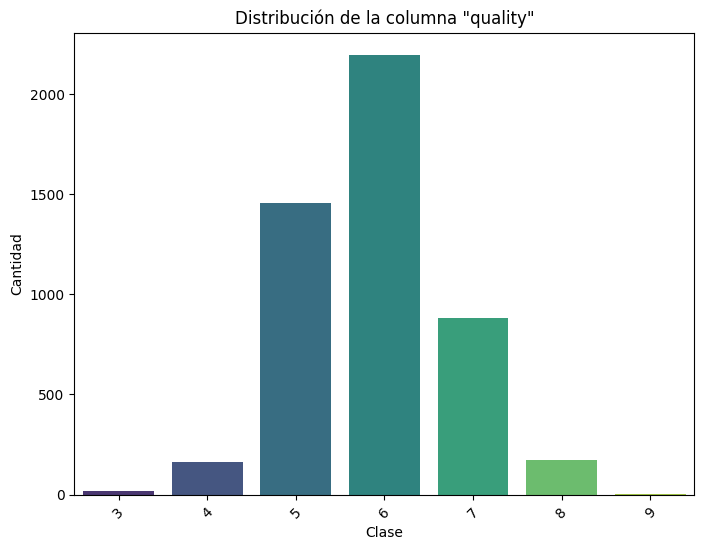

In [8]:
# Mostramos la distribucion de la variable quality
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=white, palette='viridis')
plt.title('Distribución de la columna "quality"')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Cambiamos la columna quality a malo, medio y bueno
# Malo: 0-4
# Medio malo: 5
# Medio bueno: 6
# Bueno: 7-10

white['quality'] = pd.cut(white['quality'], bins = [0, 4, 5, 6, 10], labels = ['Malo', 'Medio malo', 'Medio bueno', 'Bueno'])
white['quality'].value_counts()

quality
Medio bueno    2198
Medio malo     1457
Bueno          1060
Malo            183
Name: count, dtype: int64

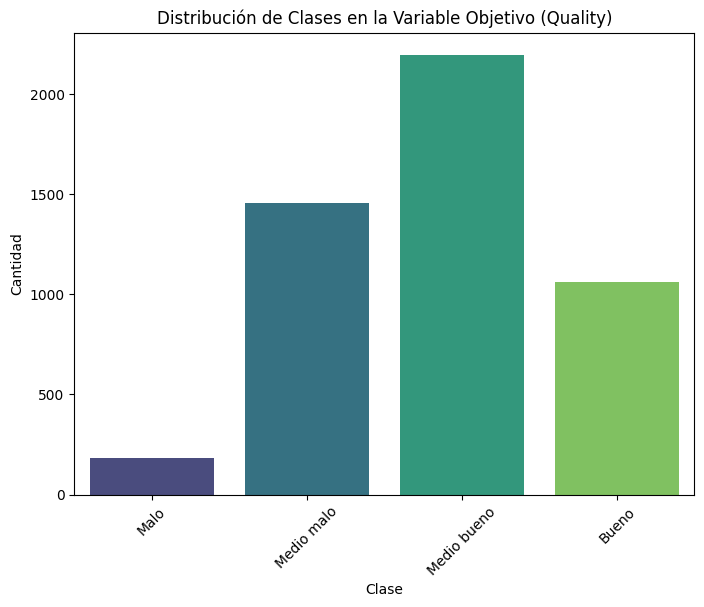

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=white, palette='viridis')
plt.title('Distribución de Clases en la Variable Objetivo (Quality)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Poner los malos como 0, los medios malos como 1, los medios buenos como 2 y los buenos como 3
white['quality'] = white['quality'].map({'Malo': 0, 'Medio malo': 1, 'Medio bueno': 2, 'Bueno': 3})
white['quality'].value_counts()


quality
2    2198
1    1457
3    1060
0     183
Name: count, dtype: int64

In [12]:
# Importante guardar una lista llamada labels para el futuro graficas con las etiquetas
labels = ['Malo', 'Medio malo', 'Medio bueno', 'Bueno']

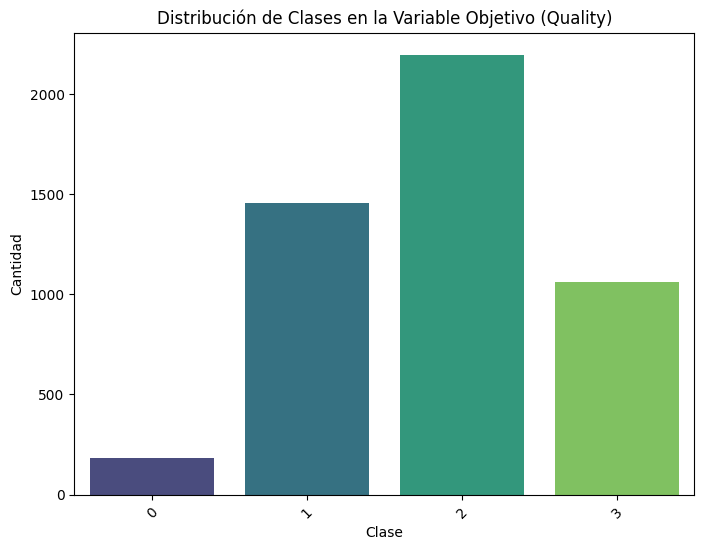

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=white, palette='viridis')
plt.title('Distribución de Clases en la Variable Objetivo (Quality)')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

# EDA

In [14]:
print("----Nulos en white_wine----")
print(white.isnull().sum(), "\n")

white.describe()

----Nulos en white_wine----
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


vemos que que las columnas son todas numericas, que no hay columnas con valores negativos

In [15]:
def corr_matrix(df, df_name):
    # Matriz de correlación
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Matriz de correlación de {df_name}')
    plt.show()

In [16]:
def show_histograms(df):
    # Graficar la distribución de las variables
    df.hist(bins=20, edgecolor='black', linewidth=1, figsize=(14, 10))

    # Ajustar las cuadrículas para que se vean menos
    for ax in plt.gcf().axes:
        ax.grid(True, alpha=0.3)  # Ajustar la transparencia de las cuadrículas

    # Agregar título principal y ajustar márgenes
    plt.suptitle('Distribución de las variables', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para evitar que el título se solape

    plt.show()

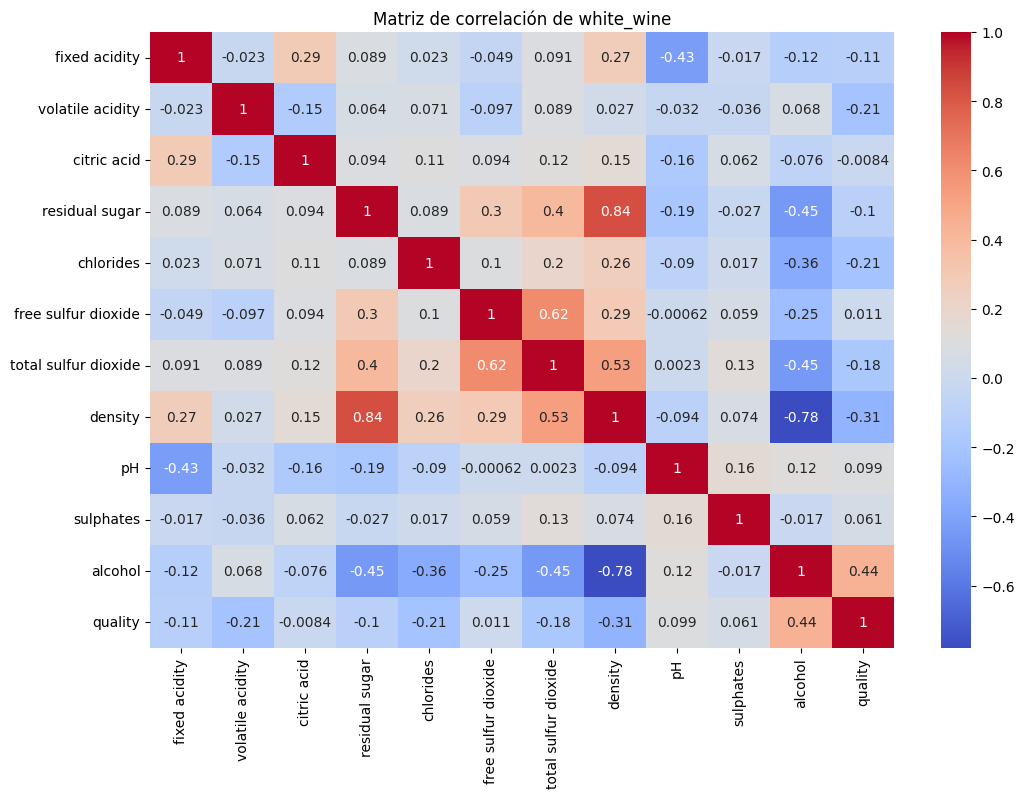

In [17]:
corr_matrix(white, 'white_wine')

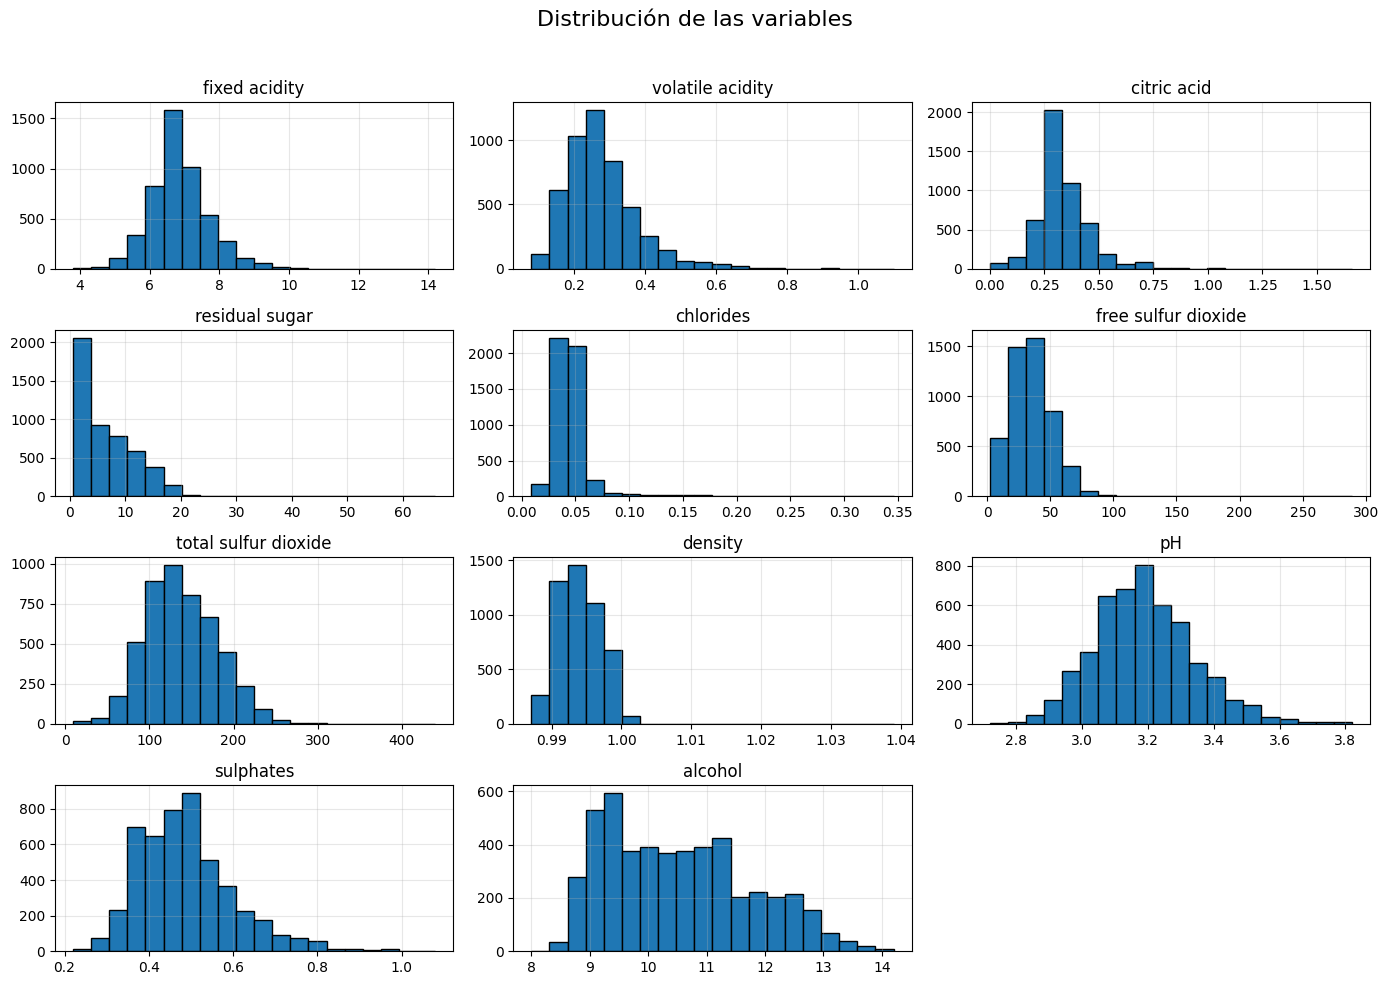

In [18]:
show_histograms(white)

Residual sugar: Tiene una distribución altamente sesgada hacia la izquierda.  
Chlorides: También presenta una distribución muy sesgada hacia la izquierda.  
Free sulfur dioxide: Es asimétrica y tiene un sesgo a la izquierda.  
Total sulfur dioxide: Tiene una forma similar a la de free sulfur dioxide.  
Sulphates: Aunque no es tan sesgada como las anteriores, aún tiene un sesgo que podría mejorar con Box-Cox.  

# Splitting de datos

In [19]:
# Establecemos una semilla para reproducibilidad
seed = np.random.seed(42)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_white = white.drop(columns=['quality'])
y_white = white['quality']

# Split 80/20
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=seed)

In [20]:
# Contamos cuántas observaciones hay en cada conjunto
print(f'Conjunto de entrenamiento: {X_train_white.shape[0]} observaciones')
print(f'Conjunto de prueba: {X_test_white.shape[0]} observaciones')

Conjunto de entrenamiento: 3918 observaciones
Conjunto de prueba: 980 observaciones


# Preprocesamiento

## Box-Cox

$$
\begin{equation}
y(\lambda) =
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{si } \lambda \neq 0 \\
\log(y) & \text{si } \lambda = 0
\end{cases}
\end{equation}
$$


In [21]:
def comparar_histogramas(df_1, df_2, col1, col2, lmbd=1):
    plt.figure(figsize=(12, 5))

    # Histograma de la primera columna (sin lambda)
    plt.subplot(1, 2, 1)
    plt.hist(df_1[col1], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col1}')
    plt.xlabel(f'Valores de {col1}')
    plt.ylabel('Frecuencia')

    # Histograma de la segunda columna (con el valor de lambda incluido en el título)
    plt.subplot(1, 2, 2)
    plt.hist(df_2[col2], bins=20, color='salmon', edgecolor='black')
    plt.title(f'Histograma de {col2} / λ = {lmbd}')
    plt.xlabel(f'Valores de {col2}')
    plt.ylabel('Frecuencia')

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

### Box-Cox manual

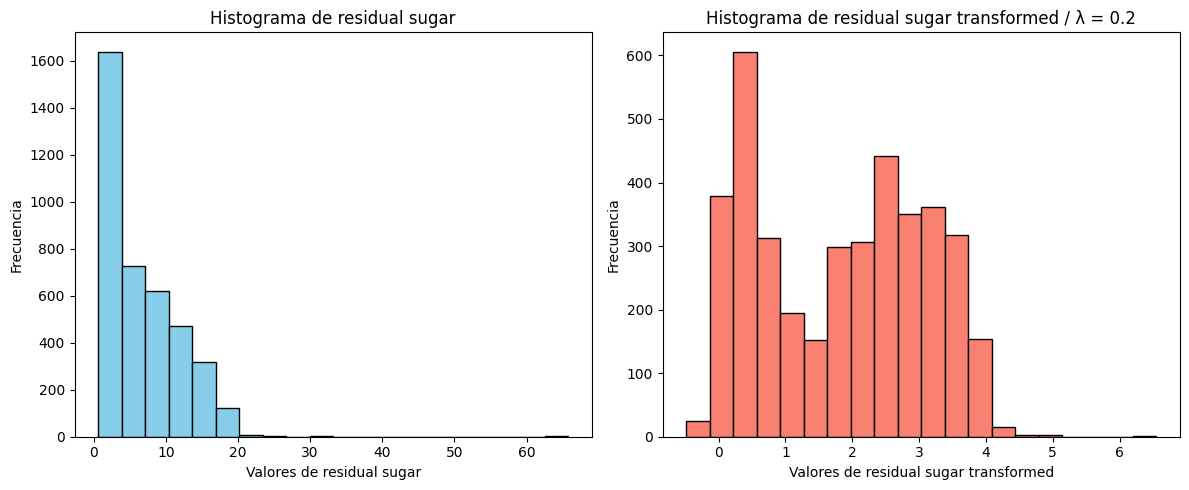

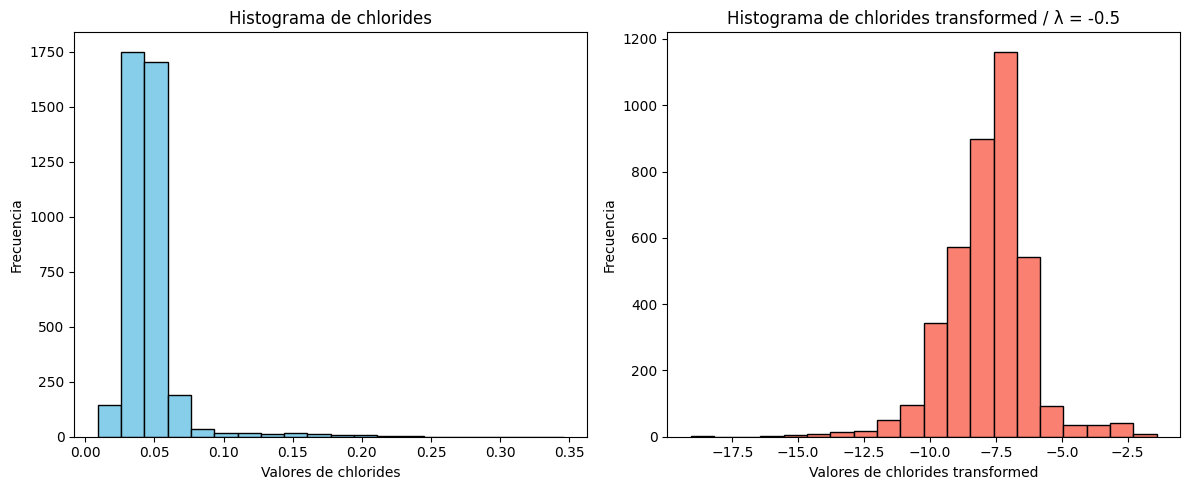

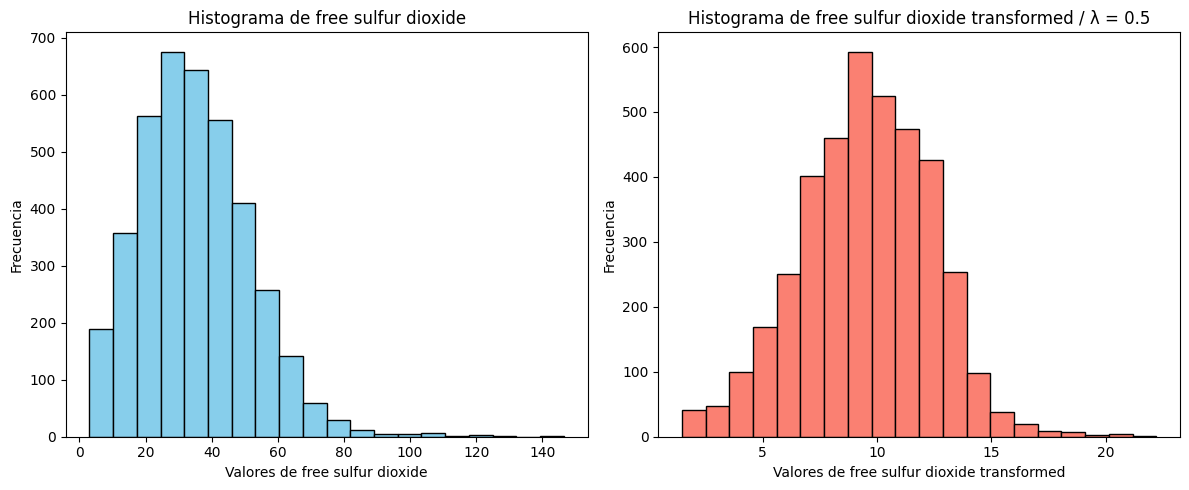

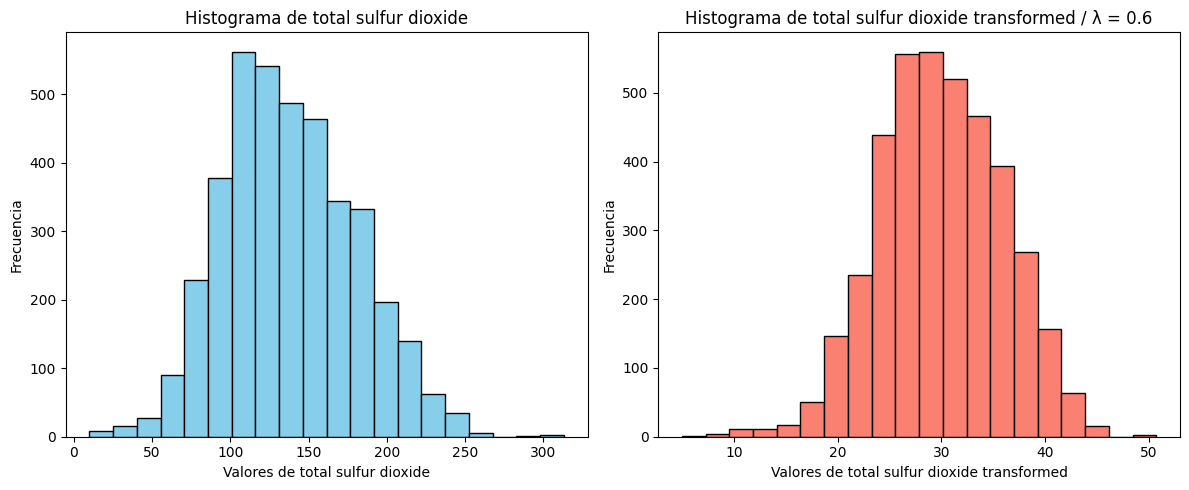

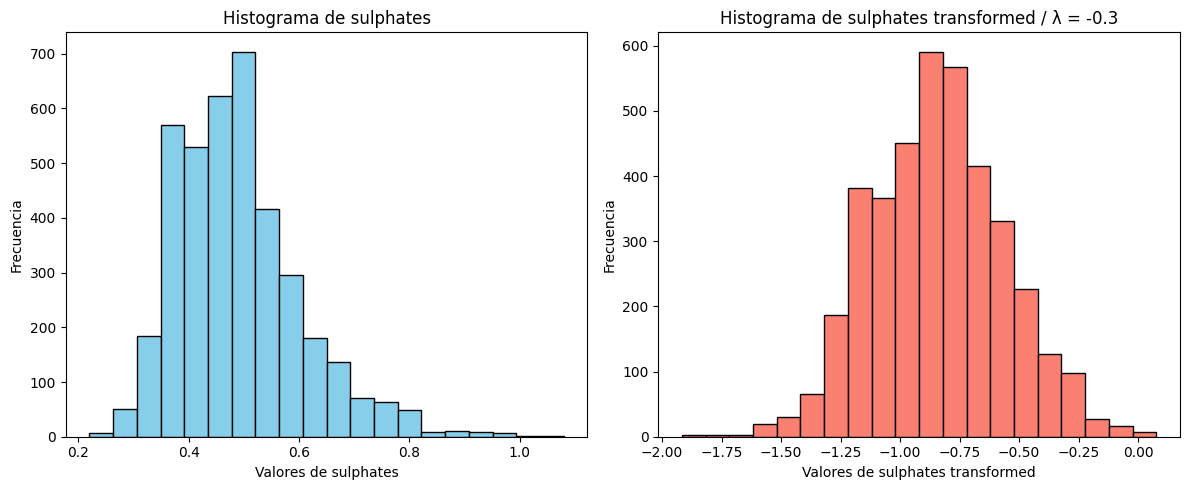

In [22]:
# Columnas a transformar: 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates'

# Duplicamos el dataset para comparar los histogramas
white_wine_manual = X_train_white.copy()

# Elegimos los valores de lambda
lambda_residual_sugar = 0.20
lambda_chlorides = -0.5
lambda_free_sulfur_dioxide = 0.5
lambda_total_sulfur_dioxide = 0.6
lambda_sulphates = -0.3

# Transformación Box-Cox
white_wine_manual['residual sugar transformed'] = boxcox(white_wine_manual['residual sugar'], lmbda=lambda_residual_sugar)
white_wine_manual['chlorides transformed'] = boxcox(white_wine_manual['chlorides'], lmbda=lambda_chlorides)
white_wine_manual['free sulfur dioxide transformed'] = boxcox(white_wine_manual['free sulfur dioxide'], lmbda=lambda_free_sulfur_dioxide)
white_wine_manual['total sulfur dioxide transformed'] = boxcox(white_wine_manual['total sulfur dioxide'], lmbda=lambda_total_sulfur_dioxide)
white_wine_manual['sulphates transformed'] = boxcox(white_wine_manual['sulphates'], lmbda=lambda_sulphates)

# Comparamos los histogramas
comparar_histogramas(X_train_white, white_wine_manual, 'residual sugar', 'residual sugar transformed', lambda_residual_sugar)
comparar_histogramas(X_train_white, white_wine_manual, 'chlorides', 'chlorides transformed', lambda_chlorides)
comparar_histogramas(X_train_white, white_wine_manual, 'free sulfur dioxide', 'free sulfur dioxide transformed', lambda_free_sulfur_dioxide)
comparar_histogramas(X_train_white, white_wine_manual, 'total sulfur dioxide', 'total sulfur dioxide transformed', lambda_total_sulfur_dioxide)
comparar_histogramas(X_train_white, white_wine_manual, 'sulphates', 'sulphates transformed', lambda_sulphates)


### Box-Cox automatico

---Función de verosimilitud---  
Para encontrar el valor óptimo de λ, Box-Cox maximiza la función de verosimilitud logarítmica.  
Esto se basa en la suposición de que los datos transformados siguen una distribución normal.  
La función de verosimilitud logarítmica que se maximiza es:  

$$
\begin{equation}
\mathcal{L}(\lambda) = 
\begin{cases} 
-\frac{n}{2} \log(\sigma^2(\lambda)) + (\lambda - 1) \sum_{i=1}^{n} \log(y_i)
\end{cases}
\end{equation}
$$


In [23]:
# Duplicamos el dataset para comparar los histogramas
X_train_white_transformed = X_train_white.copy()
X_test_white_transformed = X_test_white.copy()

# Diccionario para almacenar los valores de lambda
lambdas = {}

# Columnas a transformar: 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates'
columns_to_transform = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']

# Aplicamos la transformación Box-Cox a X_train_white_wine
for column in columns_to_transform:
    # Dado que Box-Cox solo acepta valores positivos, añadimos una pequeña constante si es necesario
    X_train_white_transformed[column], lambda_value = boxcox(X_train_white_transformed[column] + 1e-6)

    # Guardar el nombre de la columna y el valor de lambda en el diccionario
    lambdas[f'{column} λ']= float(round(lambda_value, 5))

# Aplicamos la transformacion Box-Cox a X_test_white_wine con los valores de lambda obtenidos
for column in columns_to_transform:
    # Dado que Box-Cox solo acepta valores positivos, añadimos una pequeña constante si es necesario
    X_test_white_transformed[column] = boxcox(X_test_white_transformed[column] + 1e-6, lmbda=lambdas[f'{column} λ'])


In [24]:
lambdas

{'residual sugar λ': 0.12531,
 'chlorides λ': -0.45491,
 'free sulfur dioxide λ': 0.52146,
 'total sulfur dioxide λ': 0.71384,
 'sulphates λ': -0.36917}

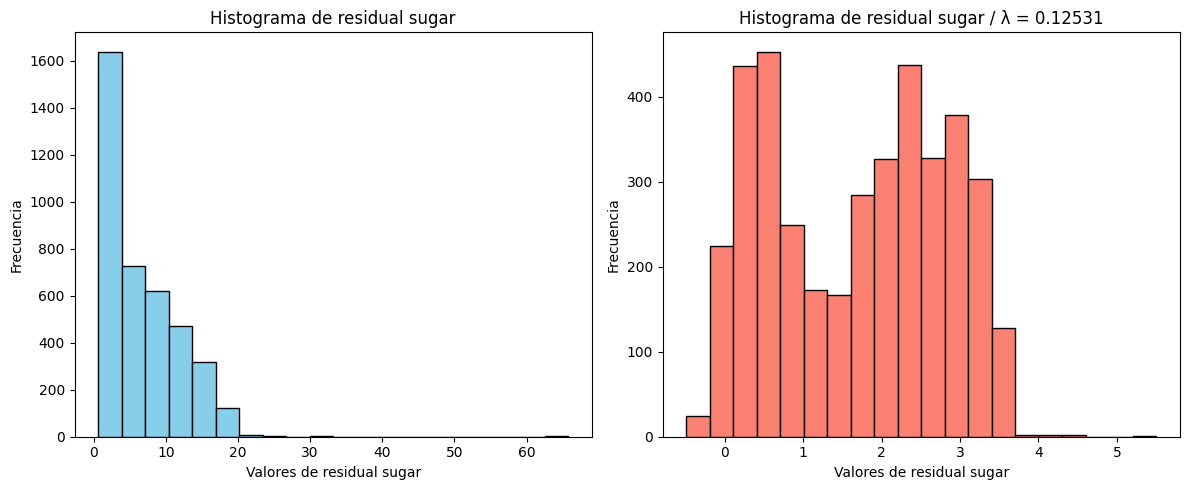

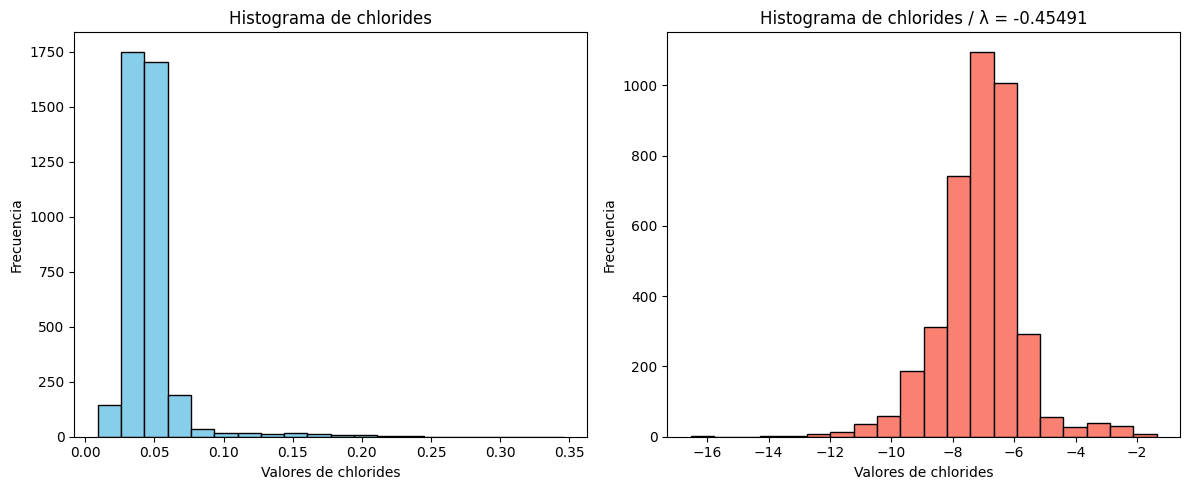

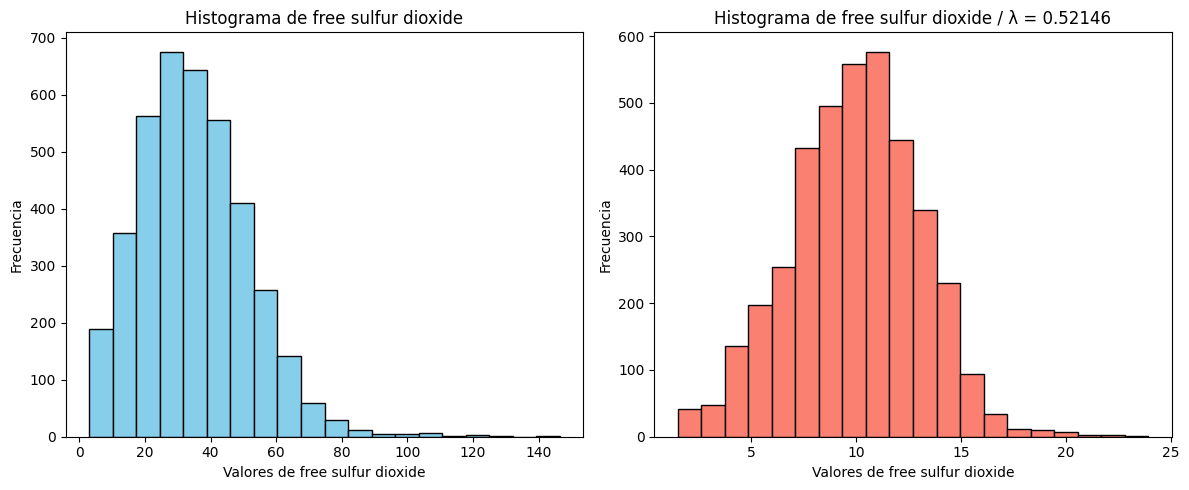

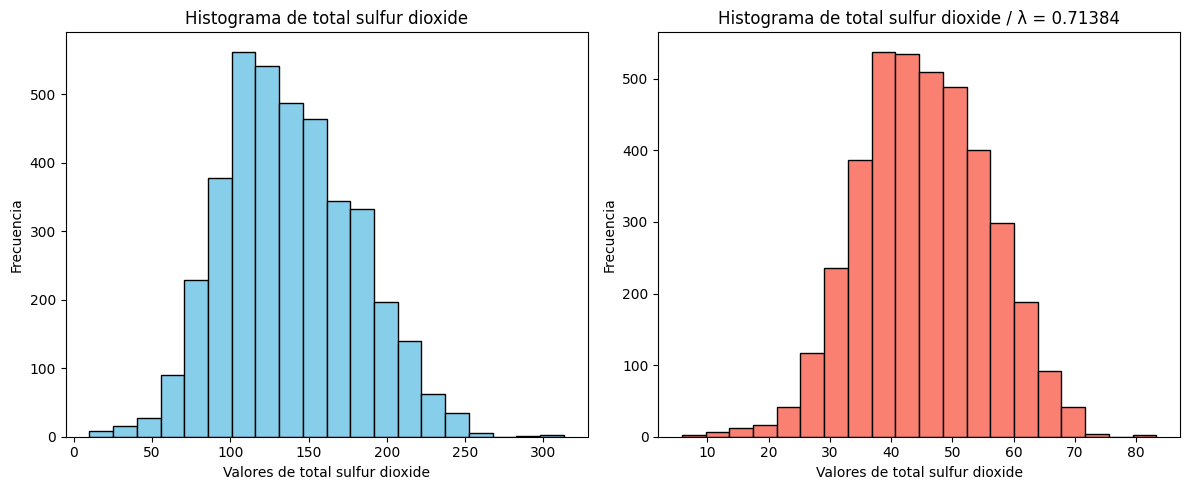

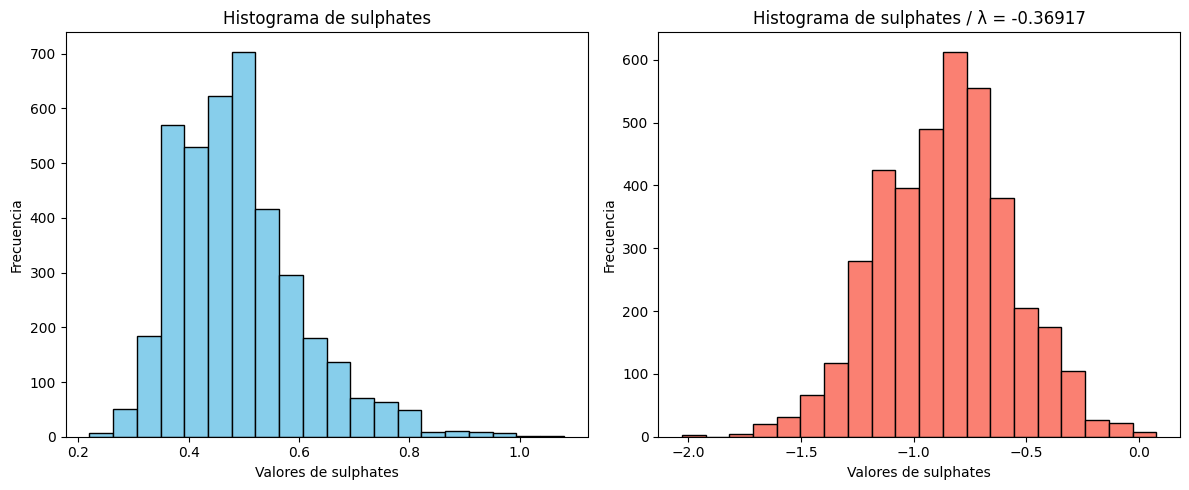

In [25]:
# Comparamos los histogramas
comparar_histogramas(X_train_white, X_train_white_transformed, 'residual sugar', 'residual sugar', lambdas['residual sugar λ'])
comparar_histogramas(X_train_white, X_train_white_transformed, 'chlorides', 'chlorides', lambdas['chlorides λ'])
comparar_histogramas(X_train_white, X_train_white_transformed, 'free sulfur dioxide', 'free sulfur dioxide', lambdas['free sulfur dioxide λ'])
comparar_histogramas(X_train_white, X_train_white_transformed, 'total sulfur dioxide', 'total sulfur dioxide', lambdas['total sulfur dioxide λ'])
comparar_histogramas(X_train_white, X_train_white_transformed, 'sulphates', 'sulphates', lambdas['sulphates λ'])

## Estandarización

In [26]:
# Definimos el escalador
scaler = MinMaxScaler()

# Escalamos las variables independientesn para el conjunto de train y test
X_train_white_scaled = scaler.fit_transform(X_train_white_transformed)
X_test_white_scaled = scaler.transform(X_test_white_transformed)

# Convertimos los arrays resultantes a DataFrames
X_train_white_scaled = pd.DataFrame(X_train_white_scaled, columns=X_train_white_transformed.columns)
X_test_white_scaled = pd.DataFrame(X_test_white_scaled, columns=X_test_white_transformed.columns)

# Modelado

## Metricas

### Principales Métricas de Evaluación para Clasificación Multinomial

- **Exactitud (Accuracy)**:
  - Proporción de predicciones correctas sobre el total de predicciones en todas las clases.
   $$\text{Exactitud} = \frac{\text{Número de predicciones correctas}}{\text{Total de predicciones}}$$

- **Precisión (Precision) macro promedio**:
  - Mide cuántas de las predicciones positivas de cada clase son realmente correctas, promediado sobre todas las clases.
   $$\text{Precisión}_{macro} = \frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FP_i}$$
  
- **Sensibilidad (Recall) macro promedio**:
  - Mide cuántos de los casos positivos reales de cada clase fueron correctamente identificados, promediado sobre todas las clases.
   $$\text{Sensibilidad}_{macro} = \frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{TP_i + FN_i}$$
  
- **F1-score macro promedio**:
  - Media armónica entre precisión y sensibilidad para cada clase, promediado sobre todas las clases.
   $$\text{F1-score}_{macro} = \frac{1}{C} \sum_{i=1}^{C} 2 \times \frac{\text{Precisión}_i \times \text{Sensibilidad}_i}{\text{Precisión}_i + \text{Sensibilidad}_i}$$

### Notación:
- **C**: Número de clases.
- **TP_i**: Verdaderos Positivos para la clase **i**.
- **FP_i**: Falsos Positivos para la clase **i**.
- **FN_i**: Falsos Negativos para la clase **i**.

### Tipos de Promedios:
- **Macro promedio**: Calcula la métrica para cada clase y luego toma el promedio, tratando a todas las clases por igual.
- **Micro promedio**: Suma los valores de todas las clases antes de calcular la métrica, ponderando según el número de muestras.


## Regresion Logistica

In [27]:
# Definir el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000, random_state=seed)

# Realizar validación cruzada en el conjunto de entrenamiento
scores = cross_val_score(logreg, X_train_white_scaled, y_train_white, cv=5)

# Mostrar los resultados de la validación cruzada
print(f"Puntajes de validación cruzada: {scores}")
print(f"Accuracy promedio: {scores.mean():.4f}")

Puntajes de validación cruzada: [0.55357143 0.53826531 0.57780612 0.55555556 0.55810983]
Accuracy promedio: 0.5567


In [28]:
# Ajustar el modelo con los datos de entrenamiento
logreg.fit(X_train_white_scaled, y_train_white)

# Predecir sobre el conjunto de prueba
y_pred_test = logreg.predict(X_test_white_scaled)

# Informe de clasificación en el conjunto de prueba
print("Informe de clasificación en el conjunto de prueba:\n", classification_report(y_test_white, y_pred_test, zero_division=0))

# Mostrar la precisión (accuracy) en el conjunto de prueba
test_accuracy = accuracy_score(y_test_white, y_pred_test)
print(f"Precisión (accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

# Mostrar la precisión (precision)
test_precision = precision_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Precisión (precision) en el conjunto de prueba: {test_precision:.4f}")

# Mostrar el recall (sensitividad)
test_recall = recall_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")

# Mostrar el F1-score
test_f1 = f1_score(y_test_white, y_pred_test, average='weighted')
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")


Informe de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.55      0.49      0.52       291
           2       0.50      0.70      0.58       432
           3       0.58      0.30      0.39       227

    accuracy                           0.52       980
   macro avg       0.41      0.37      0.37       980
weighted avg       0.52      0.52      0.50       980

Precisión (accuracy) en el conjunto de prueba: 0.5235
Precisión (precision) en el conjunto de prueba: 0.5178
Recall (sensitividad) en el conjunto de prueba: 0.5235
F1-Score en el conjunto de prueba: 0.5031


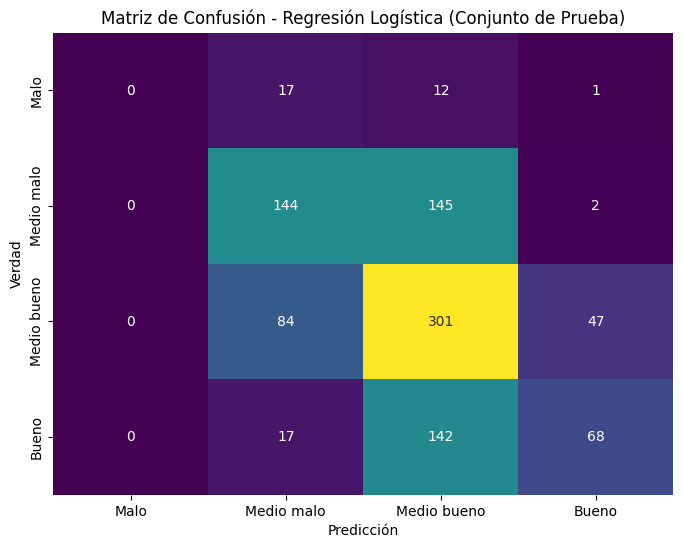

In [29]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_white, y_pred_test)

# Mostrar la matriz de confusión con un gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - Regresión Logística (Conjunto de Prueba)')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()


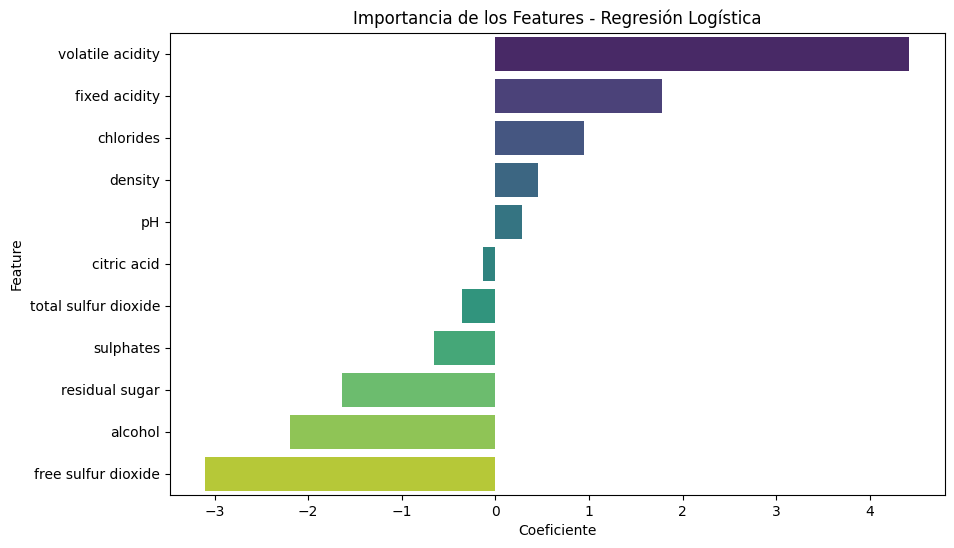

In [30]:
# Obtener los coeficientes del modelo (importancia de los features)
coefficients = logreg.coef_[0]  # Para regresión logística multiclase, puedes tener más de un coeficiente por clase

# Crear un DataFrame para visualizar la importancia de los features
features = X_train_white_scaled.columns  # Si tus features tienen nombres
feature_importance = pd.DataFrame({'Feature': features, 'Coeficiente': coefficients})

# Ordenar las características por la magnitud del coeficiente
feature_importance = feature_importance.sort_values(by='Coeficiente', ascending=False)

# Visualizar la importancia de los features en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Feature', data=feature_importance, palette='viridis')
plt.title('Importancia de los Features - Regresión Logística')
plt.show()

## ElasticNet

### Hiperparámetros de Elastic Net en la Regresión Logística

- **`l1_ratio`**:
  $$\begin{aligned}
  \text{l1\_ratio} &= 1 \quad &\Rightarrow \quad \text{Regularización Lasso (solo penalización L1)} \\
  \text{l1\_ratio} &= 0 \quad &\Rightarrow \quad \text{Regularización Ridge (solo penalización L2)} \\
  0 < \text{l1\_ratio} &< 1 \quad &\Rightarrow \quad \text{Elastic Net (combinación de Lasso y Ridge)}
  \end{aligned}$$

- **`C`**:
  
  C es el parámetro inverso de regularización:
  $$\begin{aligned}

  \quad \\
  &\text{Mayor } C \quad &\Rightarrow \quad \text{Menos regularización, mayor riesgo de sobreajuste.} \\
  &\text{Menor } C \quad &\Rightarrow \quad \text{Más regularización, menor riesgo de sobreajuste.}
  \end{aligned}$$

In [31]:
# Definir el modelo de regresión logística con penalización Elastic Net
elastic_net_logreg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, random_state=seed)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],  # ElasticNet mixing parameter
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net_logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_white_scaled, y_train_white)

# Obtener el mejor modelo
best_en_logreg = grid_search.best_estimator_

# Probar el modelo en el conjunto de test
y_pred_test = best_en_logreg.predict(X_test_white_scaled)

# Mostrar los hiperparámetros óptimos
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")

# Informe de clasificación en el conjunto de prueba
print("Informe de clasificación en el conjunto de prueba (Elastic Net):\n", classification_report(y_test_white, y_pred_test, zero_division=0))

# Mostrar la precisión en el conjunto de prueba (accuracy)
test_accuracy = accuracy_score(y_test_white, y_pred_test)
print(f"Precisión (accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

# Mostrar la precisión (precision)
test_precision = precision_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Precisión (precision) en el conjunto de prueba: {test_precision:.4f}")

# Mostrar el recall (sensitividad)
test_recall = recall_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")

# Mostrar el F1-score
test_f1 = f1_score(y_test_white, y_pred_test, average='weighted')
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejores hiperparámetros encontrados: {'C': 10, 'l1_ratio': 0.5}
Informe de clasificación en el conjunto de prueba (Elastic Net):
               precision    recall  f1-score   support

           0       0.33      0.03      0.06        30
           1       0.57      0.52      0.54       291
           2       0.51      0.70      0.59       432
           3       0.60      0.32      0.42       227

    accuracy                           0.54       980
   macro avg       0.50      0.39      0.40       980
weighted avg       0.54      0.54      0.52       980

Precisión (accuracy) en el conjunto de prueba: 0.5367
Precisión (precision) en el conjunto de prueba: 0.5425
Recall (sensitividad) en el conjunto de prueba: 0.5367
F1-Score en el conjunto de prueba: 0.5195


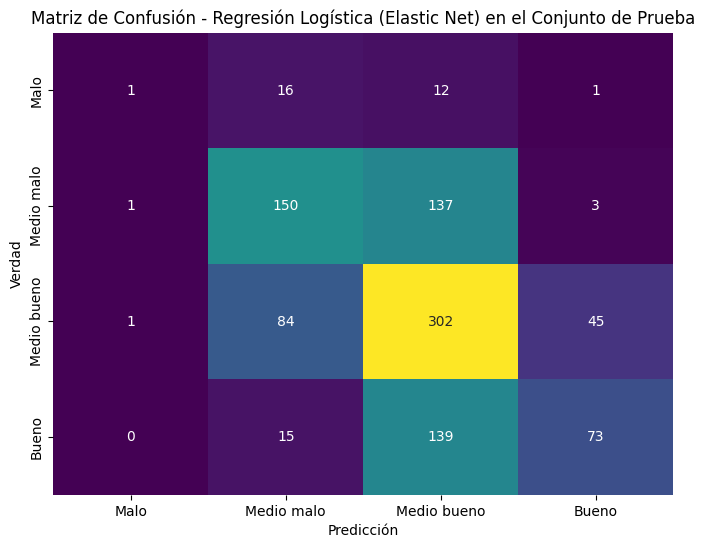

In [32]:
# Generar la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_white, y_pred_test)

# Mostrar la matriz de confusión con un gráfico para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - Regresión Logística (Elastic Net) en el Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

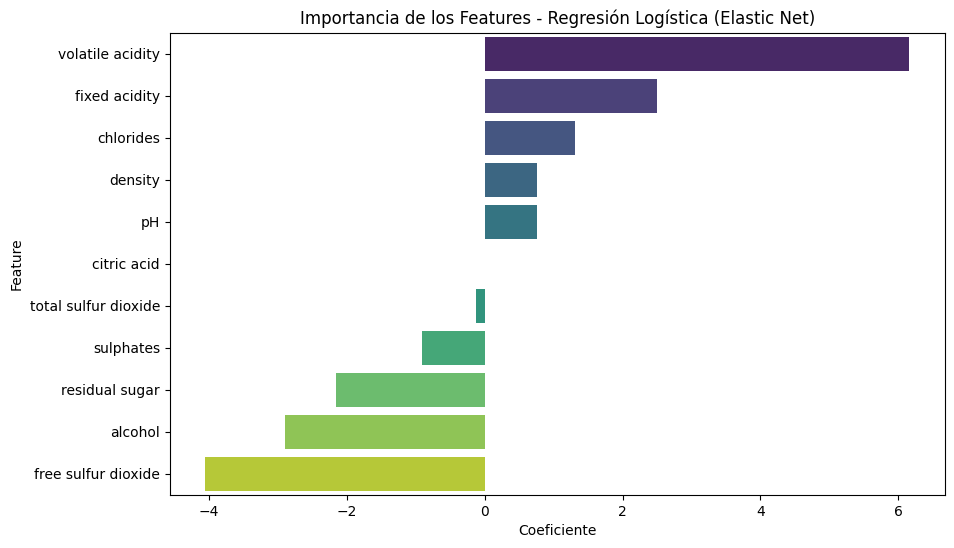

In [33]:
# Importancia de los features
coefficients_en = best_en_logreg.coef_[0]
features = X_train_white_scaled.columns  # Obtener los nombres de las columnas (features)

# Crear un DataFrame para las características y sus coeficientes
feature_importance_en = pd.DataFrame({'Feature': features, 'Coeficiente': coefficients_en})

# Ordenar las características por importancia (coeficiente)
feature_importance_en = feature_importance_en.sort_values(by='Coeficiente', ascending=False)

# Mostrar la importancia de los features en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Feature', data=feature_importance_en, palette='viridis')
plt.title('Importancia de los Features - Regresión Logística (Elastic Net)')
plt.show()

## Random Forest

Hiperparámetros de Random Forest

- **`n_estimators`**:
  - Número de árboles en el bosque.
  - Un valor más alto generalmente mejora la precisión, pero también incrementa el costo computacional.
  - Ejemplos: `100` y `200`.

- **`max_depth`**:
  - Profundidad máxima de los árboles.
  - Limitar la profundidad ayuda a prevenir el sobreajuste.
  - Valores más bajos (ej. `10`) limitan la complejidad del modelo, mientras que valores más altos (ej. `15`) permiten que los árboles crezcan más y sean más complejos.
  
- **`min_samples_split`**:
  - Número mínimo de muestras requeridas para dividir un nodo.
  - Valores más bajos (ej. `2`) permiten divisiones más profundas y árboles más complejos.
  - Valores más altos (ej. `4`) limitan la profundidad y ayudan a evitar el sobreajuste.
  
- **`min_samples_leaf`**:
  - Número mínimo de muestras necesarias en una hoja terminal.
  - Un valor más alto (ej. `4`) puede evitar que el modelo aprenda ruido al crear nodos con pocas muestras.
  
- **`max_features`**:
  - Número máximo de características consideradas para dividir un nodo.
  - **`sqrt`**: Considera la raíz cuadrada del número total de características, lo cual es un valor predeterminado y común.
  - **`log2`**: Usa el logaritmo base 2 del número total de características.
  - **`None`**: Considera todas las características para cada división.


In [34]:
# Definir el modelo de Random Forest
random_forest = RandomForestClassifier(random_state=seed)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_white_scaled, y_train_white)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred_test = best_rf.predict(X_test_white_scaled)

# Mostrar los hiperparámetros óptimos
print("Hiperparámetros óptimos encontrados por GridSearchCV:\n", grid_search.best_params_, "\n")

# Informe de clasificación en el conjunto de prueba
print("Informe de clasificación en el conjunto de prueba (Random Forest):\n", classification_report(y_test_white, y_pred_test, zero_division=0), "\n")

# Mostrar la precisión,en el conjunto de prueba
test_accuracy = accuracy_score(y_test_white, y_pred_test)
print(f"Precisión en el conjunto de prueba (accuracy): {test_accuracy:.4f}")

# Mostrar la precisión (precision)
test_precision = precision_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Precisión en el conjunto de prueba (precision): {test_precision:.4f}")

# Mostrar el recall (sensitividad)
test_recall = recall_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")

# Mostrar el F1-score
test_f1 = f1_score(y_test_white, y_pred_test, average='weighted')
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Hiperparámetros óptimos encontrados por GridSearchCV:
 {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 

Informe de clasificación en el conjunto de prueba (Random Forest):
               precision    recall  f1-score   support

           0       0.67      0.20      0.31        30
           1       0.70      0.67      0.69       291
           2       0.67      0.78      0.72       432
           3       0.83      0.69      0.75       227

    accuracy                           0.71       980
   macro avg       0.72      0.59      0.62       980
weighted avg       0.72      0.71      0.71       980
 

Precisión en el conjunto de prueba (accuracy): 0.7102
Precisión en el conjunto de prueba (precision): 0.7165
Recall (sensitividad) en el conjunto de prueba: 0.7102
F1-Score en el conjunto de prueba: 0.7060


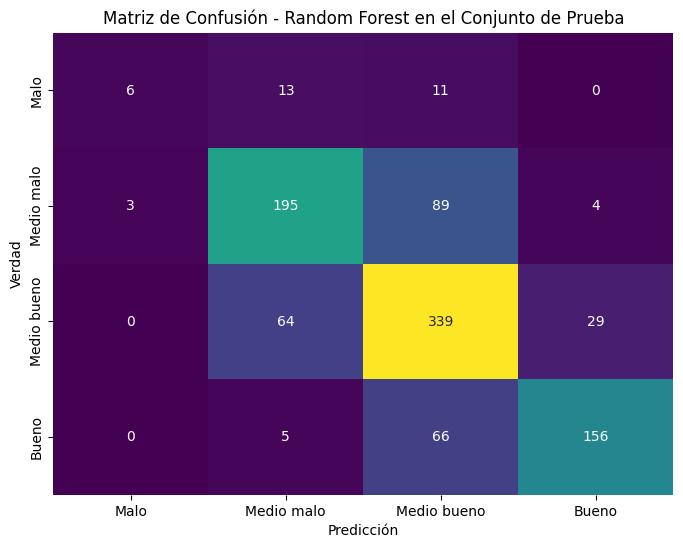

In [35]:
# Generar la matriz de confusión para el conjunto de prueba
conf_matrix_rf = confusion_matrix(y_test_white, y_pred_test)

# Mostrar la matriz de confusión con un gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - Random Forest en el Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

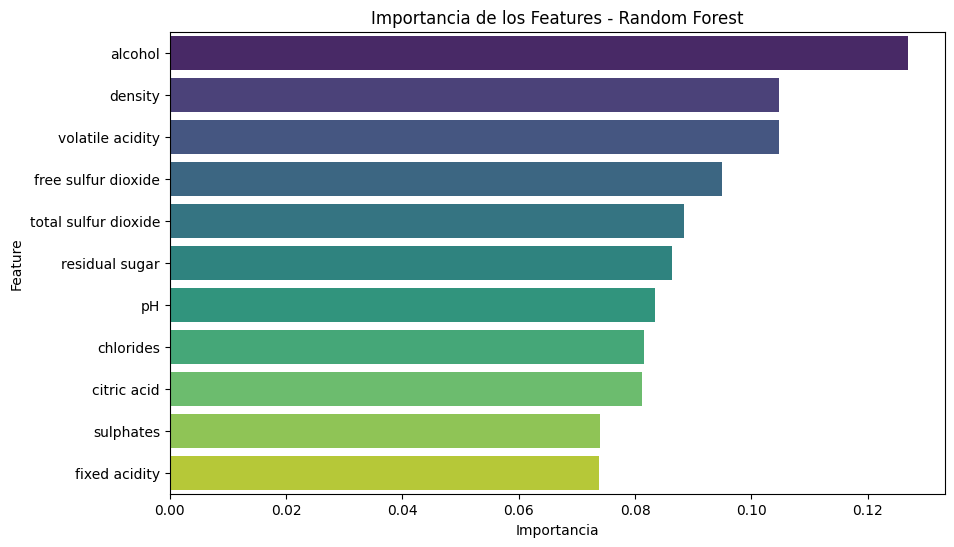

In [36]:
# Importancia de los features
importances = best_rf.feature_importances_
features = X_train_white_scaled.columns  # Obtener los nombres de las columnas (features)

# Crear un DataFrame para las características y su importancia
feature_importance_rf = pd.DataFrame({'Feature': features, 'Importancia': importances})

# Ordenar las características por importancia
feature_importance_rf = feature_importance_rf.sort_values(by='Importancia', ascending=False)

# Mostrar la importancia de los features en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=feature_importance_rf, palette='viridis')
plt.title('Importancia de los Features - Random Forest')
plt.show()

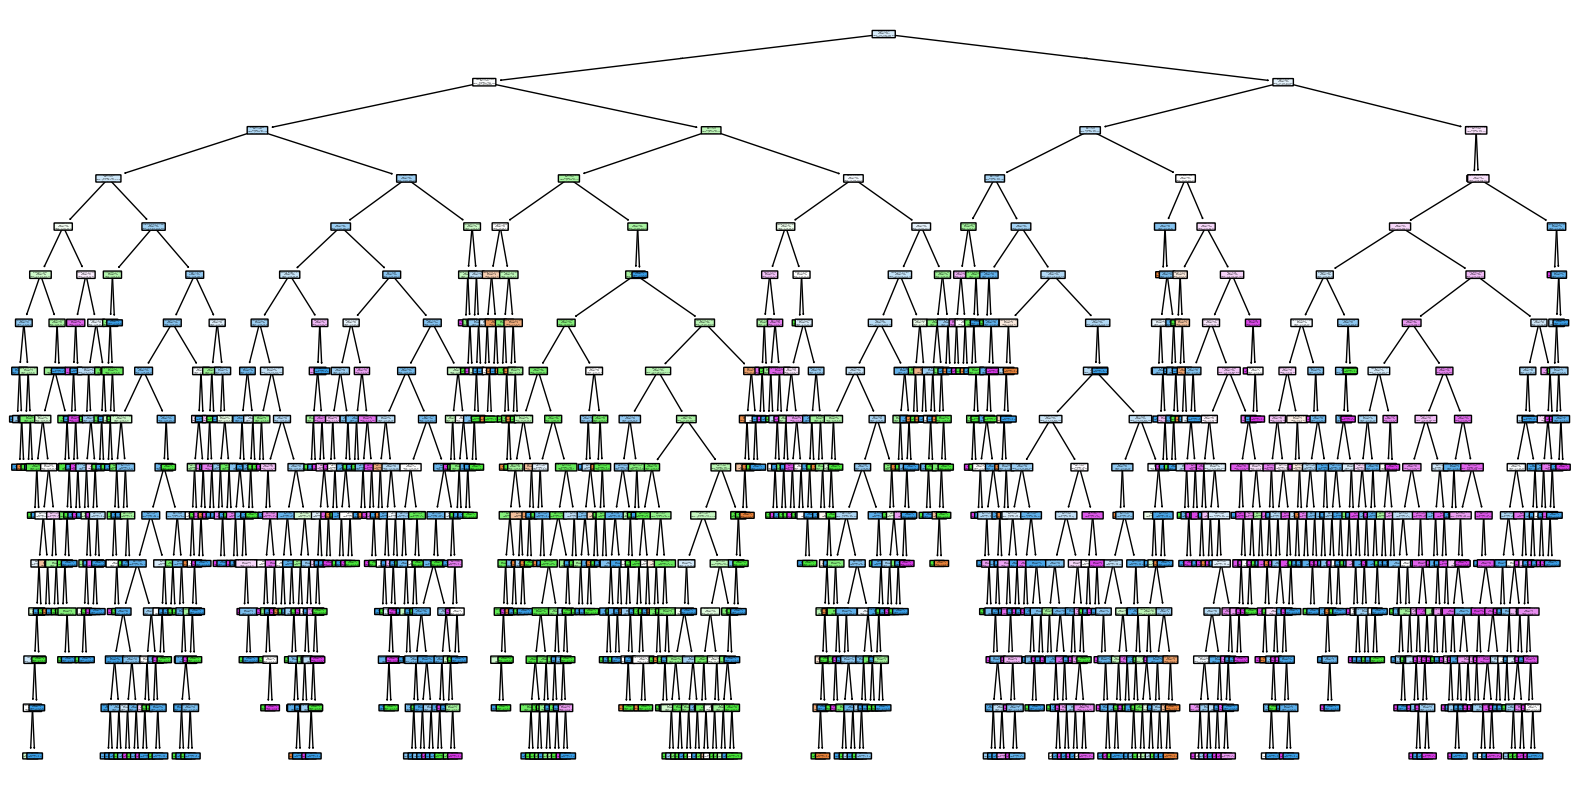

In [37]:
# Seleccionamos el primer árbol del Random Forest
estimator = best_rf.estimators_[0]

# Graficar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(estimator, feature_names=X_train_white_scaled.columns, filled=True, rounded=True, class_names=['Malo', 'Medio Malo', 'Medio Bueno', 'Bueno'])
plt.show()

## SVM (SVC - Support Vector Classifier)

Hiperparámetros de SVC (Support Vector Classifier)

- **`C`**:
  - Controla la penalización por error de clasificación en el conjunto de entrenamiento.
  - Valores bajos de `C` (ej. 0.1) permiten márgenes más amplios, pero pueden tolerar más errores de clasificación.
  - Valores altos de `C` (ej. 100) ajustan más estrictamente los datos, lo que podría conducir a un sobreajuste.
  
- **`gamma`**:
  - Controla la influencia de un solo punto de entrenamiento.
  - **`gamma` bajo** (ej. 0.001) significa que los puntos lejanos tienen una influencia más amplia, lo que genera un modelo más suave.
  - **`gamma` alto** (ej. 1) significa que cada punto solo tiene influencia local, lo que podría generar un sobreajuste si no se ajusta bien.
  
- **`kernel`**:
  - Especifica la función del kernel que transforma los datos a un espacio de mayor dimensionalidad.
    - **`linear`**: No transforma los datos, mantiene un espacio lineal.
    - **`rbf` (Radial Basis Function)**: Kernel no lineal que transforma los datos usando una función gaussiana. Ideal para datos no lineales.
    - **`poly` (Polynomial)**: Aplica un kernel polinómico, útil cuando la relación entre las clases es polinómica.
    - **`sigmoid`**: Similar a una función sigmoide utilizada en redes neuronales. Se utiliza menos frecuentemente.
    
- **`degree`** (solo relevante si `kernel='poly'`):
  - Define el grado del polinomio para el kernel polinómico.
  - Valores comunes: `2`, `3`, `4`. A mayor grado, más complejo es el polinomio usado.

In [38]:
# Definir el modelo SVM
svm_model = SVC(random_state=seed)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4]  # Solo relevante si kernel='poly'
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_white_scaled, y_train_white)

# Obtener el mejor modelo
best_svm = grid_search.best_estimator_

# Probar el modelo en el conjunto de test
y_pred_test = best_svm.predict(X_test_white_scaled)

# Mostrar los hiperparámetros óptimos
print("Hiperparámetros óptimos encontrados por GridSearchCV:\n", grid_search.best_params_, "\n")

# Informe de clasificación en el conjunto de prueba
print("Informe de clasificación en el conjunto de prueba (SVM):\n", classification_report(y_test_white, y_pred_test, zero_division=0))

# Mostrar más métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test_white, y_pred_test)
test_precision = precision_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
test_recall = recall_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_white, y_pred_test, average='weighted')

print(f"Precisión (accuracy) en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Precisión (precision) en el conjunto de prueba: {test_precision:.4f}")
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Hiperparámetros óptimos encontrados por GridSearchCV:
 {'C': 100, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'} 

Informe de clasificación en el conjunto de prueba (SVM):
               precision    recall  f1-score   support

           0       0.62      0.27      0.37        30
           1       0.62      0.58      0.60       291
           2       0.56      0.71      0.63       432
           3       0.69      0.45      0.54       227

    accuracy                           0.60       980
   macro avg       0.62      0.50      0.54       980
weighted avg       0.61      0.60      0.59       980

Precisión (accuracy) en el conjunto de prueba: 0.6000
Precisión (precision) en el conjunto de prueba: 0.6120
Recall (sensitividad) en el conjunto de prueba: 0.6000
F1-Score en el conjunto de prueba: 0.5941


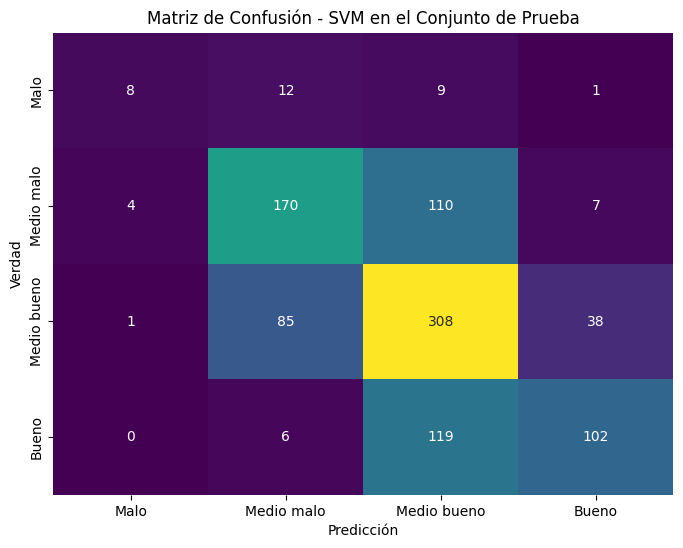

In [39]:
# Generar la matriz de confusión en el conjunto de prueba
conf_matrix_svm = confusion_matrix(y_test_white, y_pred_test)

# Definir las etiquetas personalizadas
labels = ['Malo', 'Medio malo', 'Medio bueno', 'Bueno']

# Mostrar la matriz de confusión con etiquetas personalizadas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - SVM en el Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

El mejor modelo no utiliza un kernel lineal. Calculando la importancia mediante Permutational Feature Importance...


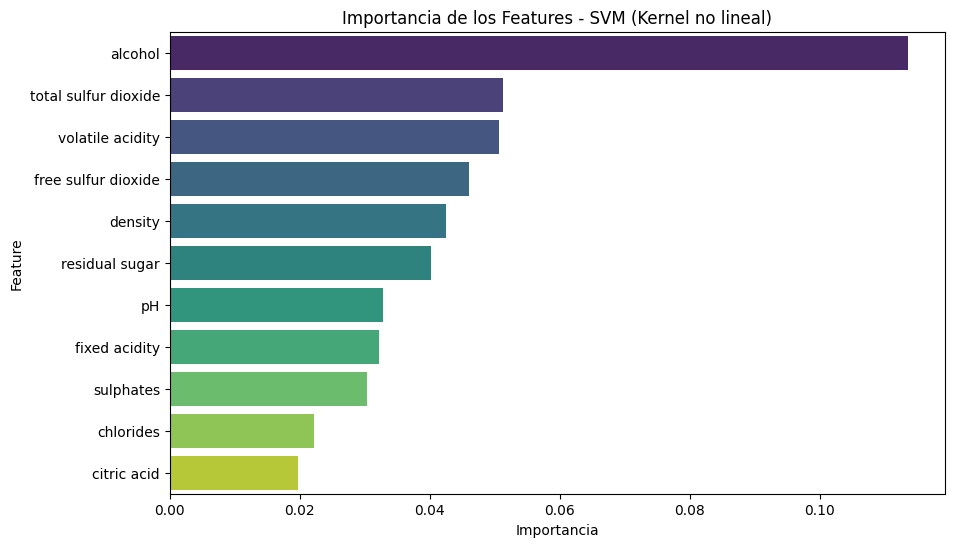

In [40]:
# Importancia de los features
if best_svm.kernel == 'linear':
    # Importancia de los features (solo para kernel='linear')
    coefficients_svm = best_svm.coef_.flatten()  # Aplanar el coeficiente para el kernel lineal
    features = X_train_white_scaled.columns  # Obtener los nombres de las columnas (features)

    # Crear un DataFrame para las características y su coeficiente
    feature_importance_svm = pd.DataFrame({'Feature': features, 'Coeficiente': coefficients_svm})

    # Ordenar las características por importancia
    feature_importance_svm = feature_importance_svm.sort_values(by='Coeficiente', ascending=False)

    # Mostrar la importancia de los features en un gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coeficiente', y='Feature', data=feature_importance_svm, palette='viridis')
    plt.title('Importancia de los Features - SVM (Kernel Lineal)')
    plt.show()
else:
    # Si el kernel no es 'linear', usar Permutational Feature Importance
    print("El mejor modelo no utiliza un kernel lineal. Calculando la importancia mediante Permutational Feature Importance...")

    # Calcular la importancia por permutación
    perm_importance = permutation_importance(best_svm, X_test_white_scaled, y_test_white, n_repeats=10, random_state=42, n_jobs=-1)

    # Crear un DataFrame para las características y su importancia
    feature_importance_perm = pd.DataFrame({'Feature': X_train_white_scaled.columns, 'Importancia': perm_importance.importances_mean})

    # Ordenar las características por importancia
    feature_importance_perm = feature_importance_perm.sort_values(by='Importancia', ascending=False)

    # Mostrar la importancia de los features en un gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importancia', y='Feature', data=feature_importance_perm, palette='viridis')
    plt.title('Importancia de los Features - SVM (Kernel no lineal)')
    plt.show()

## XGBoost

Hiperparámetros de XGBoost

- **`n_estimators`**:
  - Número de árboles a entrenar en el modelo.
  - **Mayor número** de árboles puede aumentar la capacidad del modelo, pero también puede llevar al sobreajuste.
  
- **`max_depth`**:
  - Profundidad máxima de cada árbol.
  - **Mayor profundidad** permite al modelo capturar patrones más complejos, pero también puede llevar al sobreajuste.
  
- **`learning_rate`**:
  - Tasa de aprendizaje que controla el peso que se le da a cada árbol en el ensamblado.
  - **Tasas bajas** (ej. `0.01`) requieren más árboles (más iteraciones) para ajustar el modelo, pero pueden mejorar la generalización.
  
- **`subsample`**:
  - Proporción de los datos utilizados para entrenar cada árbol.
  - **Valores menores** a 1 (ej. `0.8`) pueden ayudar a reducir el sobreajuste al hacer el modelo menos dependiente de una única muestra.
  
- **`colsample_bytree`**:
  - Fracción de características que se utilizan en cada árbol.
  - **Valores menores** a 1 pueden reducir el sobreajuste y acelerar el entrenamiento al utilizar solo una parte de las características en cada árbol.


In [41]:
# Definir el modelo de XGBoost
xgboost_model = xgb.XGBClassifier(random_state=seed)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]}
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train_white_scaled, y_train_white)

# Obtener el mejor modelo
best_xgb = grid_search.best_estimator_

# Probar el modelo en el conjunto de test
y_pred_test = best_xgb.predict(X_test_white_scaled)

# Mostrar los hiperparámetros óptimos
print("Hiperparámetros óptimos encontrados por GridSearchCV:\n", grid_search.best_params_, "\n")

# Informe de clasificación en el conjunto de prueba
print("Informe de clasificación en el conjunto de prueba (XGBoost):\n", classification_report(y_test_white, y_pred_test, zero_division=0))

# Mostrar más métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test_white, y_pred_test)
test_precision = precision_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
test_recall = recall_score(y_test_white, y_pred_test, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_white, y_pred_test, average='weighted')

print(f"Precisión (accuracy) en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Precisión (precision) en el conjunto de prueba: {test_precision:.4f}")
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\palva\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Hiperparámetros óptimos encontrados por GridSearchCV:
 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} 

Informe de clasificación en el conjunto de prueba (XGBoost):
               precision    recall  f1-score   support

           0       0.65      0.43      0.52        30
           1       0.71      0.69      0.70       291
           2       0.68      0.76      0.72       432
           3       0.78      0.67      0.73       227

    accuracy                           0.71       980
   macro avg       0.71      0.64      0.67       980
weighted avg       0.71      0.71      0.71       980

Precisión (accuracy) en el conjunto de prueba: 0.7092
Precisión (precision) en el conjunto de prueba: 0.7126
Recall (sensitividad) en el conjunto de prueba: 0.7092
F1-Score en el conjunto de prueba: 0.7082


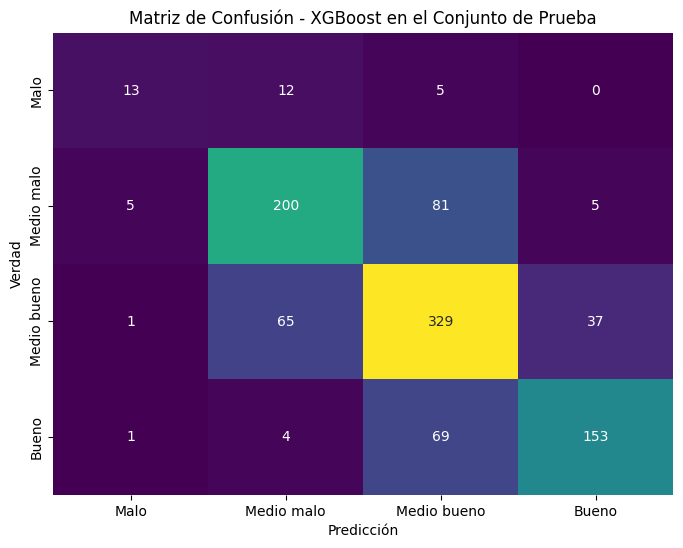

In [42]:
# Generar la matriz de confusión en el conjunto de prueba
conf_matrix_xgb = confusion_matrix(y_test_white, y_pred_test)

# Definir las etiquetas personalizadas
labels = ['Malo', 'Medio malo', 'Medio bueno', 'Bueno']

# Mostrar la matriz de confusión con etiquetas personalizadas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - XGBoost en el Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

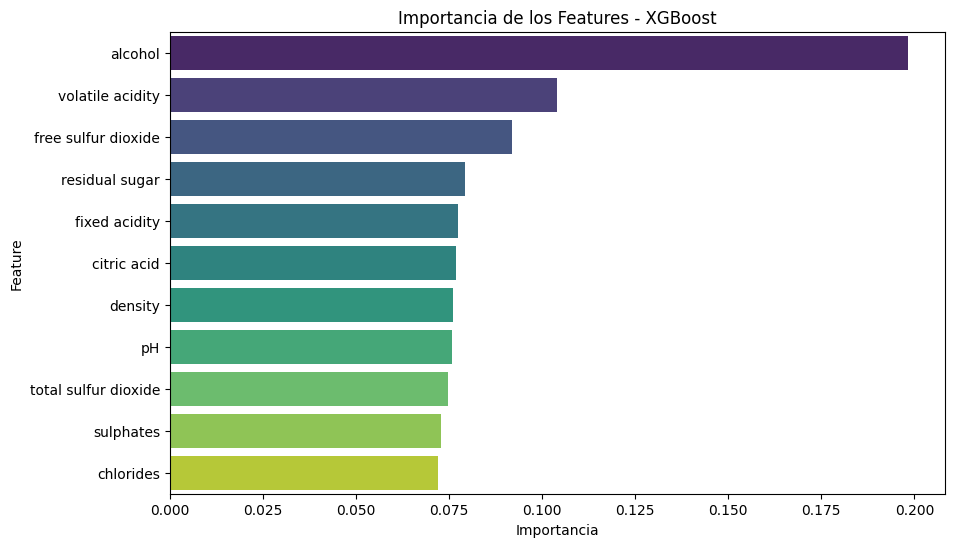

In [43]:
# Importancia de los features
importances = best_xgb.feature_importances_
features = X_train_white_scaled.columns  # Obtener los nombres de las columnas (features)

# Crear un DataFrame para las características y su importancia
feature_importance_xgb = pd.DataFrame({'Feature': features, 'Importancia': importances})

# Ordenar las características por importancia
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importancia', ascending=False)

# Mostrar la importancia de los features en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=feature_importance_xgb, palette='viridis')
plt.title('Importancia de los Features - XGBoost')
plt.show()

## Deep Learning

In [44]:
# Convertir las etiquetas en categorías (one-hot encoding) si es multiclase
y_train_cat = to_categorical(y_train_white)
y_test_cat = to_categorical(y_test_white)

tf.random.set_seed(seed)

# Definir el modelo de red neuronal
model = Sequential()

# Capa de entrada (input layer) usando Input en lugar de input_dim
model.add(Input(shape=(X_train_white_scaled.shape[1],)))
model.add(Dense(128, activation='relu'))

# Capa oculta (hidden layer)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Agregar dropout para evitar sobreajuste

# Capa de salida (output layer), para clasificación multiclase
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_white_scaled, y_train_cat, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Predecir sobre el conjunto de prueba
y_pred_test = model.predict(X_test_white_scaled)
y_pred_classes = np.argmax(y_pred_test, axis=1)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4413 - loss: 1.2232 - val_accuracy: 0.4987 - val_loss: 1.0862
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4958 - loss: 1.0942 - val_accuracy: 0.5510 - val_loss: 1.0228
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5219 - loss: 1.0395 - val_accuracy: 0.5459 - val_loss: 0.9893
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5213 - loss: 1.0011 - val_accuracy: 0.5536 - val_loss: 0.9785
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5433 - loss: 1.0034 - val_accuracy: 0.5357 - val_loss: 0.9956
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5465 - loss: 0.9721 - val_accuracy: 0.5574 - val_loss: 0.9725
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5300 - loss: 0.9924 - val_accuracy: 0.5587 - val_loss: 0.9788
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 0.9745 - val_accuracy: 0.5472 - v

In [49]:
# Evaluar el modelo con las métricas
print("Informe de clasificación en el conjunto de prueba (Deep Learning):\n", classification_report(y_test_white, y_pred_classes))

# Mostrar más métricas en el conjunto de prueba
test_accuracy = accuracy_score(y_test_white, y_pred_classes)
test_precision = precision_score(y_test_white, y_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_white, y_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_white, y_pred_classes, average='weighted')

print(f"Precisión (accuracy) en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Precisión (precision) en el conjunto de prueba: {test_precision:.4f}")
print(f"Recall (sensitividad) en el conjunto de prueba: {test_recall:.4f}")
print(f"F1-Score en el conjunto de prueba: {test_f1:.4f}")

Informe de clasificación en el conjunto de prueba (Deep Learning):
               precision    recall  f1-score   support

           0       0.53      0.27      0.36        30
           1       0.64      0.53      0.58       291
           2       0.55      0.70      0.62       432
           3       0.60      0.47      0.52       227

    accuracy                           0.58       980
   macro avg       0.58      0.49      0.52       980
weighted avg       0.59      0.58      0.58       980

Precisión (accuracy) en el conjunto de prueba: 0.5816
Precisión (precision) en el conjunto de prueba: 0.5878
Recall (sensitividad) en el conjunto de prueba: 0.5816
F1-Score en el conjunto de prueba: 0.5763


In [45]:
# Mostrar un resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,158 (117.81 KB)

 Trainable params: 10,052 (39.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,106 (78.54 KB)

-- Resumen de la arquitectura de la red neuronal

El modelo se compone de varias capas secuenciales, cada una con una cantidad específica de parámetros entrenables y una forma de salida definida:

| **Layer (type)**       | **Output Shape** | **Param #**  |
|------------------------|------------------|--------------|
| **dense (Dense)**       | (None, 128)      | 1,536        |
| **dense_1 (Dense)**     | (None, 64)       | 8,256        |
| **dropout (Dropout)**   | (None, 64)       | 0            |
| **dense_2 (Dense)**     | (None, 4)        | 260          |

### Descripción de las capas:

1. **Capa densa (dense)**:
   - La primera capa totalmente conectada (**Dense**) tiene 128 neuronas y toma una entrada con una dimensión no especificada (`None`) para permitir flexibilidad en el tamaño del batch. El número de parámetros entrenables es 1,536, calculado como:  
     $$\text{Parámetros} = (\text{entradas} + 1) \times \text{número de neuronas} = (11 + 1) \times 128 = 1,536$$  
     (Incluye los 11 pesos de entrada por neurona y un término de sesgo).

2. **Capa densa 1 (dense_1)**:
   - La segunda capa completamente conectada tiene 64 neuronas y 8,256 parámetros entrenables. El cálculo de los parámetros es:  
     $$\text{Parámetros} = (128 + 1) \times 64 = 8,256$$  
     (128 pesos más un término de sesgo para cada neurona).

3. **Capa de Dropout**:
   - Esta capa tiene una función de regularización, descartando el 20% de las neuronas durante cada paso de entrenamiento para evitar el sobreajuste. No tiene parámetros entrenables (0 parámetros).

4. **Capa de salida (dense_2)**:
   - La última capa tiene 4 neuronas (una para cada clase si es un problema de clasificación con 4 clases). El número total de parámetros es 260:  
     $$\text{Parámetros} = (64 + 1) \times 4 = 260$$



### Parámetros totales:

- **Total de parámetros**: 30,158 (117.81 KB) - Es la suma de todos los parámetros entrenables y no entrenables.
- **Parámetros entrenables**: 10,052 (39.27 KB) - Todos los parámetros que el modelo ajusta durante el entrenamiento.
- **Parámetros no entrenables**: 0 - No hay parámetros fijos en este modelo.
- **Parámetros del optimizador**: 20,106 (78.54 KB) - Los parámetros adicionales del optimizador utilizado (en este caso **Adam**).

Este resumen proporciona una visión clara de la arquitectura y complejidad del modelo, destacando el número de capas, neuronas y parámetros entrenables.


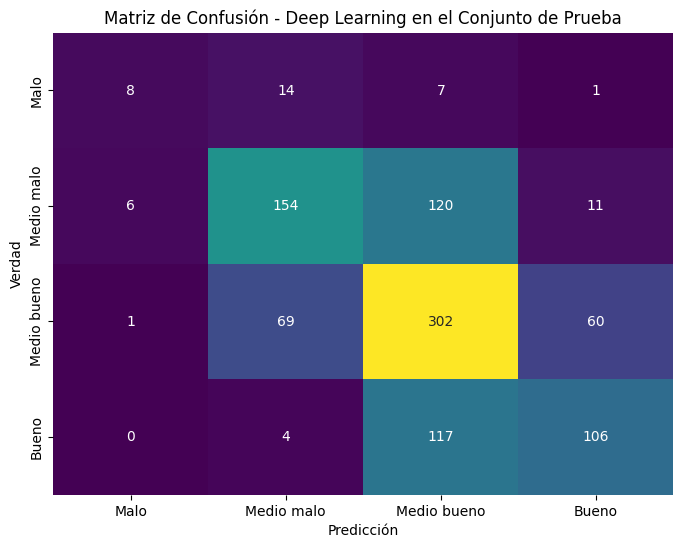

In [46]:
# Generar la matriz de confusión en el conjunto de prueba
conf_matrix_dl = confusion_matrix(y_test_white, y_pred_classes)

# Mostrar la matriz de confusión con etiquetas personalizadas
labels = ['Malo', 'Medio malo', 'Medio bueno', 'Bueno']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dl, annot=True, fmt='d', cmap='viridis', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión - Deep Learning en el Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.show()

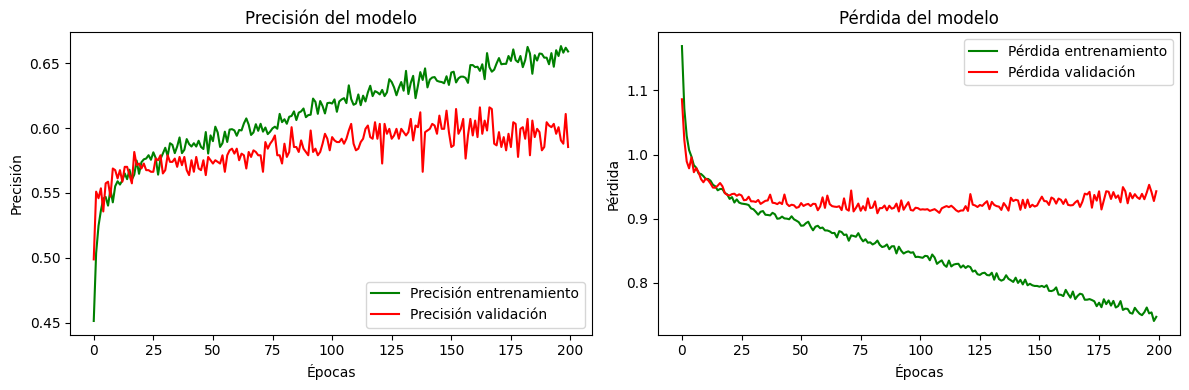

In [47]:
# Mostrar el gráfico de entrenamiento (accuracy y loss)
plt.figure(figsize=(12, 4))

# Precisión del modelo a lo largo de las épocas
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento', color = 'green')
plt.plot(history.history['val_accuracy'], label='Precisión validación', color = 'red')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Épocas')
plt.legend(loc='lower right')

# Pérdida (loss) del modelo a lo largo de las épocas
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida entrenamiento', color = 'green')
plt.plot(history.history['val_loss'], label='Pérdida validación', color = 'red')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Épocas')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


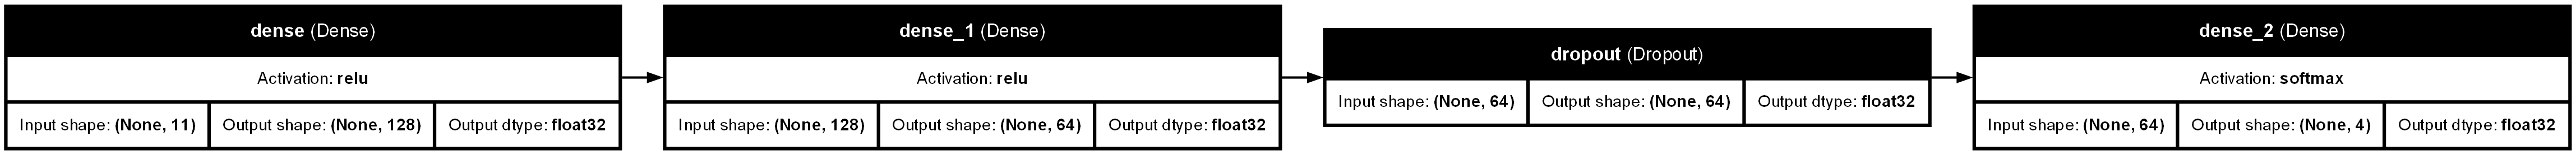

In [48]:
try:
    # Graficar el modelo con opciones personalizadas
    plot_model(
        model,
        to_file='modelo_neuronal.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='LR',  # Orientación de izquierda a derecha
        show_dtype=True,  # Mostrar tipos de datos
        show_layer_activations=True,  # Mostrar las activaciones
        dpi=150  # Aumentar la resolución
    )

    # Mostrar la imagen directamente en el notebook
    display(Image(filename='modelo_neuronal.png'))
except Exception as e:
    print("No se pudo generar el gráfico del modelo.", e)